In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
data=pd.read_csv("Eluvio_DS_Challenge.csv")
data

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,25-01-2008,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,25-01-2008,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,25-01-2008,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,25-01-2008,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,25-01-2008,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews
...,...,...,...,...,...,...,...,...
509231,1479816764,22-11-2016,5,0,Heil Trump : Donald Trump s alt-right white...,False,nonamenoglory,worldnews
509232,1479816772,22-11-2016,1,0,There are people speculating that this could b...,False,SummerRay,worldnews
509233,1479817056,22-11-2016,1,0,Professor receives Arab Researchers Award,False,AUSharjah,worldnews
509234,1479817157,22-11-2016,1,0,Nigel Farage attacks response to Trump ambassa...,False,smilyflower,worldnews


In [4]:
len(set(data['author']))

85807

**Most Popular Topics**

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
data['title']

0                         Scores killed in Pakistan clashes
1                          Japan resumes refuelling mission
2                           US presses Egypt on Gaza border
3              Jump-start economy: Give health care to all 
4           Council of Europe bashes EU&UN terror blacklist
                                ...                        
509231     Heil Trump : Donald Trump s  alt-right  white...
509232    There are people speculating that this could b...
509233            Professor receives Arab Researchers Award
509234    Nigel Farage attacks response to Trump ambassa...
509235    Palestinian wielding knife shot dead in West B...
Name: title, Length: 509236, dtype: object

In [7]:
from nltk import pos_tag
from nltk import word_tokenize
words_tokenized = [[w.lower() for w in word_tokenize(t)] for t in data['title']]
data['tokenized_title'] = words_tokenized
pos_tag(data['tokenized_title'][0])

[('scores', 'NNS'),
 ('killed', 'VBN'),
 ('in', 'IN'),
 ('pakistan', 'NN'),
 ('clashes', 'NNS')]

In [8]:
len(list(data['tokenized_title']))

509236

In [9]:
data['pos_title'] = data['tokenized_title'].map(lambda t: [t[1] for t in pos_tag(t)])
data['pos_title'].head(5)

0                   [NNS, VBN, IN, NN, NNS]
1                        [NN, VBZ, VBG, NN]
2                [PRP, VBZ, NN, IN, NN, NN]
3           [JJ, NN, :, JJ, NN, NN, TO, DT]
4    [NN, IN, NN, NNS, VBP, CC, JJ, NN, NN]
Name: pos_title, dtype: object

In [13]:
pos_tag

<function nltk.tag.pos_tag(tokens, tagset=None, lang='eng')>

In [14]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
data['stemmed_title'] = data['tokenized_title'].map(
    lambda wl: [stemmer.stem(w) for w in wl]
)

In [15]:
def topic(df):
    tags = df['pos_title']
    stems = df['stemmed_title']
    return [stem for (tag, stem) in zip(tags, stems) if tag in ['NN', 'NNS']]

In [16]:
data['topics'] = data.apply(topic, axis='columns')
data['topics'].head()


0                     [score, pakistan, clash]
1                             [japan, mission]
2                        [egypt, gaza, border]
3                      [economi, health, care]
4    [council, europ, bash, terror, blacklist]
Name: topics, dtype: object

In [17]:
topic_counts = pd.Series(np.concatenate(data['topics'].values)).value_counts()
topic_counts.head()
topic_counts[1:].head(10)

china     21658
attack    18447
world     17996
year      16576
govern    16198
state     16052
polic     15916
syria     15903
russia    15620
presid    15263
dtype: int64

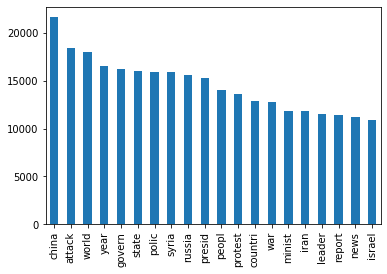

In [18]:
topic_counts[1:].head(20).plot(kind='bar')

**As you can see topics on China are used highly** 

**Most popular topics by sentiments**

In [19]:
!pip install twython

  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.1.0-py2.py3-none-any.whl (147 kB)


You should consider upgrading via the 'C:\Users\Admin\anaconda3\python.exe -m pip install --upgrade pip' command.


In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


In [21]:
top_1000 = topic_counts.sort_values(ascending=False).head(1000)
top_1000_sentiments = [sid.polarity_scores(w)['compound'] for w in top_1000.index]

In [22]:
tmp = pd.DataFrame(top_1000).assign(sentiment=top_1000_sentiments)

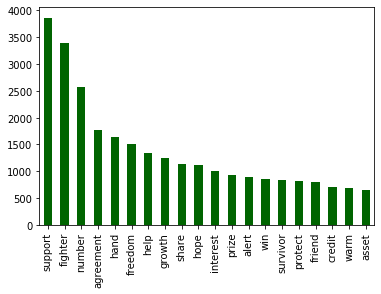

In [23]:
tmp.query('sentiment > 0').head(20)[0].plot(kind='bar', color='darkgreen')

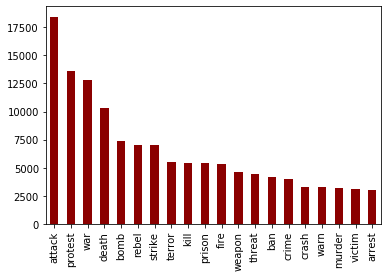

In [24]:
tmp.query('sentiment < 0').head(20)[0].plot(kind='bar', color='darkred')

**Analysed article volume over its lifespan**

In [25]:
data['date_created'].replace(regex=True,inplace=True,to_replace="-",value="")
data['publish_month_year'] = data.date_created.str[2:8]
data['publish_year'] = data.date_created.str[4:8]

data['publish_day'] = data.date_created.str[:2]
years=data['publish_year'].unique().tolist()
print (years)
data.head()
data['dt_date'] = pd.to_datetime(data['date_created'], format='%d%m%Y')
data['dt_month'] = pd.to_datetime(data['publish_month_year'], format='%m%Y')

grp_date = data.groupby(['dt_date'])['title'].count()
grp_month = data.groupby(['dt_month'])['title'].count()

['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']


**Article Frequency per month** 

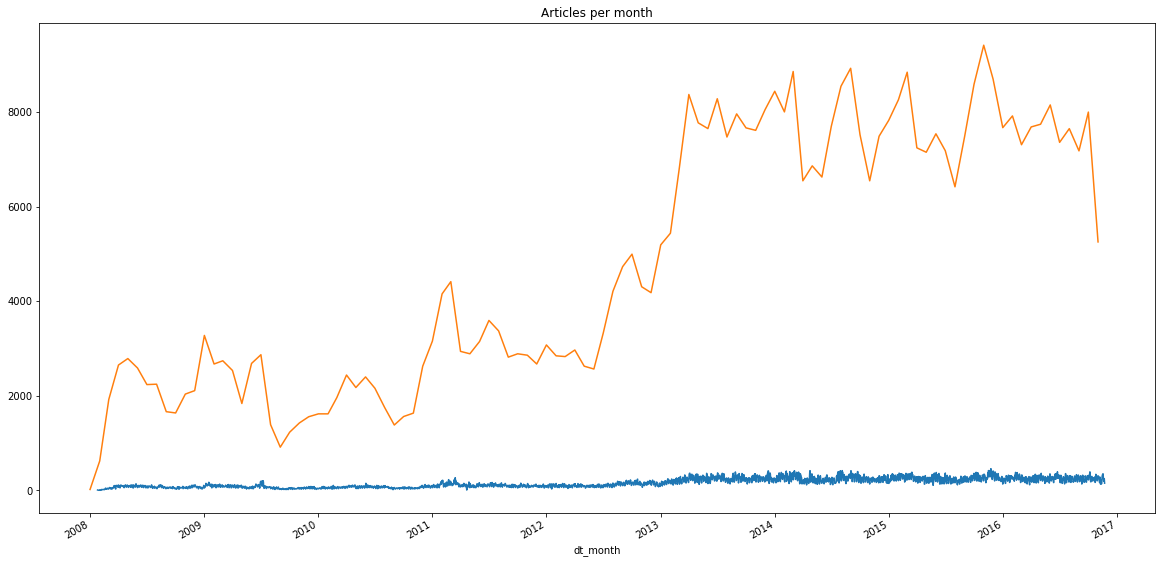

In [26]:
dt = pd.Series(grp_date)
dt.plot(kind='line', figsize=(20,10),title='Articles per day')
#plt.show()

dt = pd.Series(grp_month)
dt.plot(kind='line', figsize=(20,10),title='Articles per month')
plt.show()

**Article Frequency per month with every overlapping year**

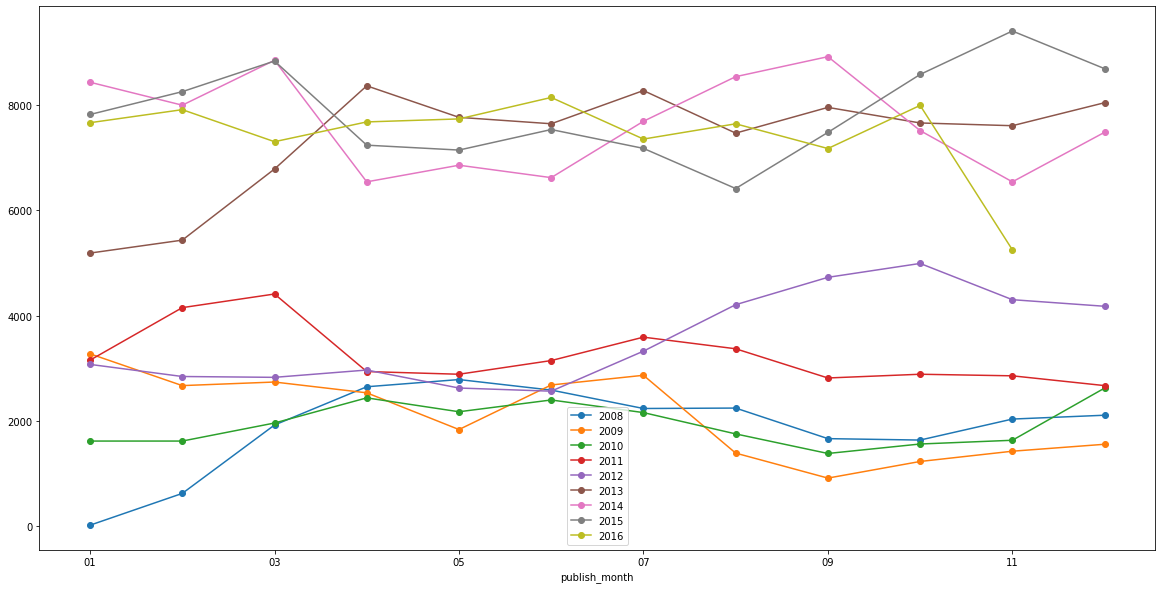

In [27]:
data['publish_month'] = data.date_created.str[2:4]
for yr in years:
    yr_slice = data.loc[data.publish_year==yr]
    grp_month = yr_slice.groupby(['publish_month'])['title'].count()
    month = pd.Series(grp_month)
    month.plot(kind='line', figsize=(20,10), style='o-', legend=True, label=yr)
    
plt.show()

**Upvotes influenced by the time of the day**

In [28]:
def TS(timestamp):
    secondOfDay = int(timestamp)%(24*60*60)
    return secondOfDay/(60*60)

data['hours_of_day'] = data['time_created'].apply(TS)
sortedUps = data.sort_values('up_votes',ascending=False)
bestData = sortedUps[:1000]
print(bestData['up_votes'])
#number of votes of the best posts:

377200    21253
391415    13435
450818    13244
391318    12333
390252    11288
          ...  
421794     5756
383611     5755
427438     5751
428368     5750
342313     5747
Name: up_votes, Length: 1000, dtype: int64


C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


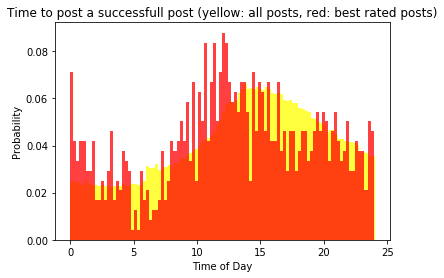

In [29]:
plt.hist(data['hours_of_day'], 100, facecolor='yellow', normed=1, alpha=0.75)
plt.hist(bestData['hours_of_day'], 100, facecolor='red', normed=1, alpha=0.75)
plt.xlabel('Time of Day')
plt.ylabel('Probability')
plt.title('Time to post a successfull post (yellow: all posts, red: best rated posts)')
plt.show()

In [30]:
list(data.columns)

['time_created',
 'date_created',
 'up_votes',
 'down_votes',
 'title',
 'over_18',
 'author',
 'category',
 'tokenized_title',
 'pos_title',
 'stemmed_title',
 'topics',
 'publish_month_year',
 'publish_year',
 'publish_day',
 'dt_date',
 'dt_month',
 'publish_month',
 'hours_of_day']

**As the column category has 1 value i.e "worldnews" and all "down_votes" have value 0 it adds no value hence drop the 2 columns**

In [31]:
data_ = data.drop("down_votes", axis = 1)
data_ = data_.drop("category", axis = 1)


In [34]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [35]:
data['tokenized_title']

0                   [scores, killed, in, pakistan, clashes]
1                     [japan, resumes, refuelling, mission]
2                    [us, presses, egypt, on, gaza, border]
3         [jump-start, economy, :, give, health, care, t...
4         [council, of, europe, bashes, eu, &, un, terro...
                                ...                        
509231    [heil, trump, :, donald, trump, s, alt-right, ...
509232    [there, are, people, speculating, that, this, ...
509233      [professor, receives, arab, researchers, award]
509234    [nigel, farage, attacks, response, to, trump, ...
509235    [palestinian, wielding, knife, shot, dead, in,...
Name: tokenized_title, Length: 509236, dtype: object

In [36]:

# To get the stems of words in a sentence.
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# To get the words themself in a sentence.
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [37]:
title = data.title.str.lower()


In [38]:
def tokenized_stemmed(title):
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in title:
        allwords_stemmed = tokenize_and_stem(i) 
        totalvocab_stemmed.extend(allwords_stemmed) 

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)
    return totalvocab_stemmed, totalvocab_tokenized

In [39]:
totalvocab_stemmed_, totalvocab_tokenized_ = tokenized_stemmed(title)


In [40]:
totalvocab_stemmed, totalvocab_tokenized  = totalvocab_stemmed_, totalvocab_tokenized_ 

In [41]:

# Build stopwords set. Combine two common set.
import sklearn.feature_extraction.text as text
stopwords = nltk.corpus.stopwords.words('english')
my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df =10**-3 ,analyzer = 'word', max_features=len(set(totalvocab_stemmed)), stop_words=my_stop_words, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(title)

print(tfidf_matrix.shape)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', "n't", 'need', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sha', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'whe

(509236, 1825)


In [43]:

thre = np.quantile(data_['up_votes'], 0.8)
y = [1 if i > thre else 0 for i in data_['up_votes']]
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size = 0.2, shuffle = True, random_state = 42)

In [44]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [45]:
y_predict = clf.predict(X_test)
clf.score(X_test, y_test)

0.8050820831042338

In [46]:
print(classification_report(y_test, y_predict))


              precision    recall  f1-score   support

           0       0.81      1.00      0.89     81988
           1       0.58      0.00      0.00     19860

    accuracy                           0.81    101848
   macro avg       0.69      0.50      0.45    101848
weighted avg       0.76      0.81      0.72    101848



In [47]:
LR = LogisticRegression(C=1.0, penalty='l2', tol=0.01)


In [48]:
LR.fit(X_train, y_train)


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False)

In [49]:
y_predict = LR.predict(X_test)
LR.score(X_test, y_test)

0.806368313565313

In [50]:
print(classification_report(y_test, y_predict))


              precision    recall  f1-score   support

           0       0.81      0.99      0.89     81988
           1       0.55      0.04      0.07     19860

    accuracy                           0.81    101848
   macro avg       0.68      0.52      0.48    101848
weighted avg       0.76      0.81      0.73    101848

